### Printed and handwritten text extraction from images using Tesseract and Google Cloud Vision API

Text extraction from image files is an useful technique for document digitalization. There are several well developed OCR engines for printed text extraction, such as Tesseract and EasyOCR [1]. However, for handwritten text extraction, it's more challenging because of large variations in handwritings from person to person. Tesseract and EasyOCR can't achieve satisfacting results unless the texts are hand printed. In this post, I will describe how to use Tesseract to extract printed texts, and use Google Cloud Vision API to extract handwritten texts.
<br>
<br>
The example text image file is from the IAM handwriting dataset [2]. 
<br>
<br>
The following major tools are used:<br>

**OpenCV**, For finding structures in the images to automatically break the images into printed segments and handwritten segments<br>
**Google Cloud Vision API**, For extract text from handwriting segment<br>
**Tesseract and Pytesseract**, For extract text from printed segment<br>


In [1]:
%reset -sf
from IPython.display import Image
from matplotlib import pyplot as plt
import pandas as pd, numpy as np
pd.options.display.float_format = '{:,.2f}'.format

from google.cloud import vision
import io

import warnings
warnings.simplefilter("ignore")

import os, cv2
os.chdir(r'C:\Users\....')
         
fileList = [x for x in os.listdir() if 'png'  in x.lower()]
fileList[:5]

['a01-000x.png', 'Oncogene Page 1.PNG', 'Oncogene Page 2.PNG']

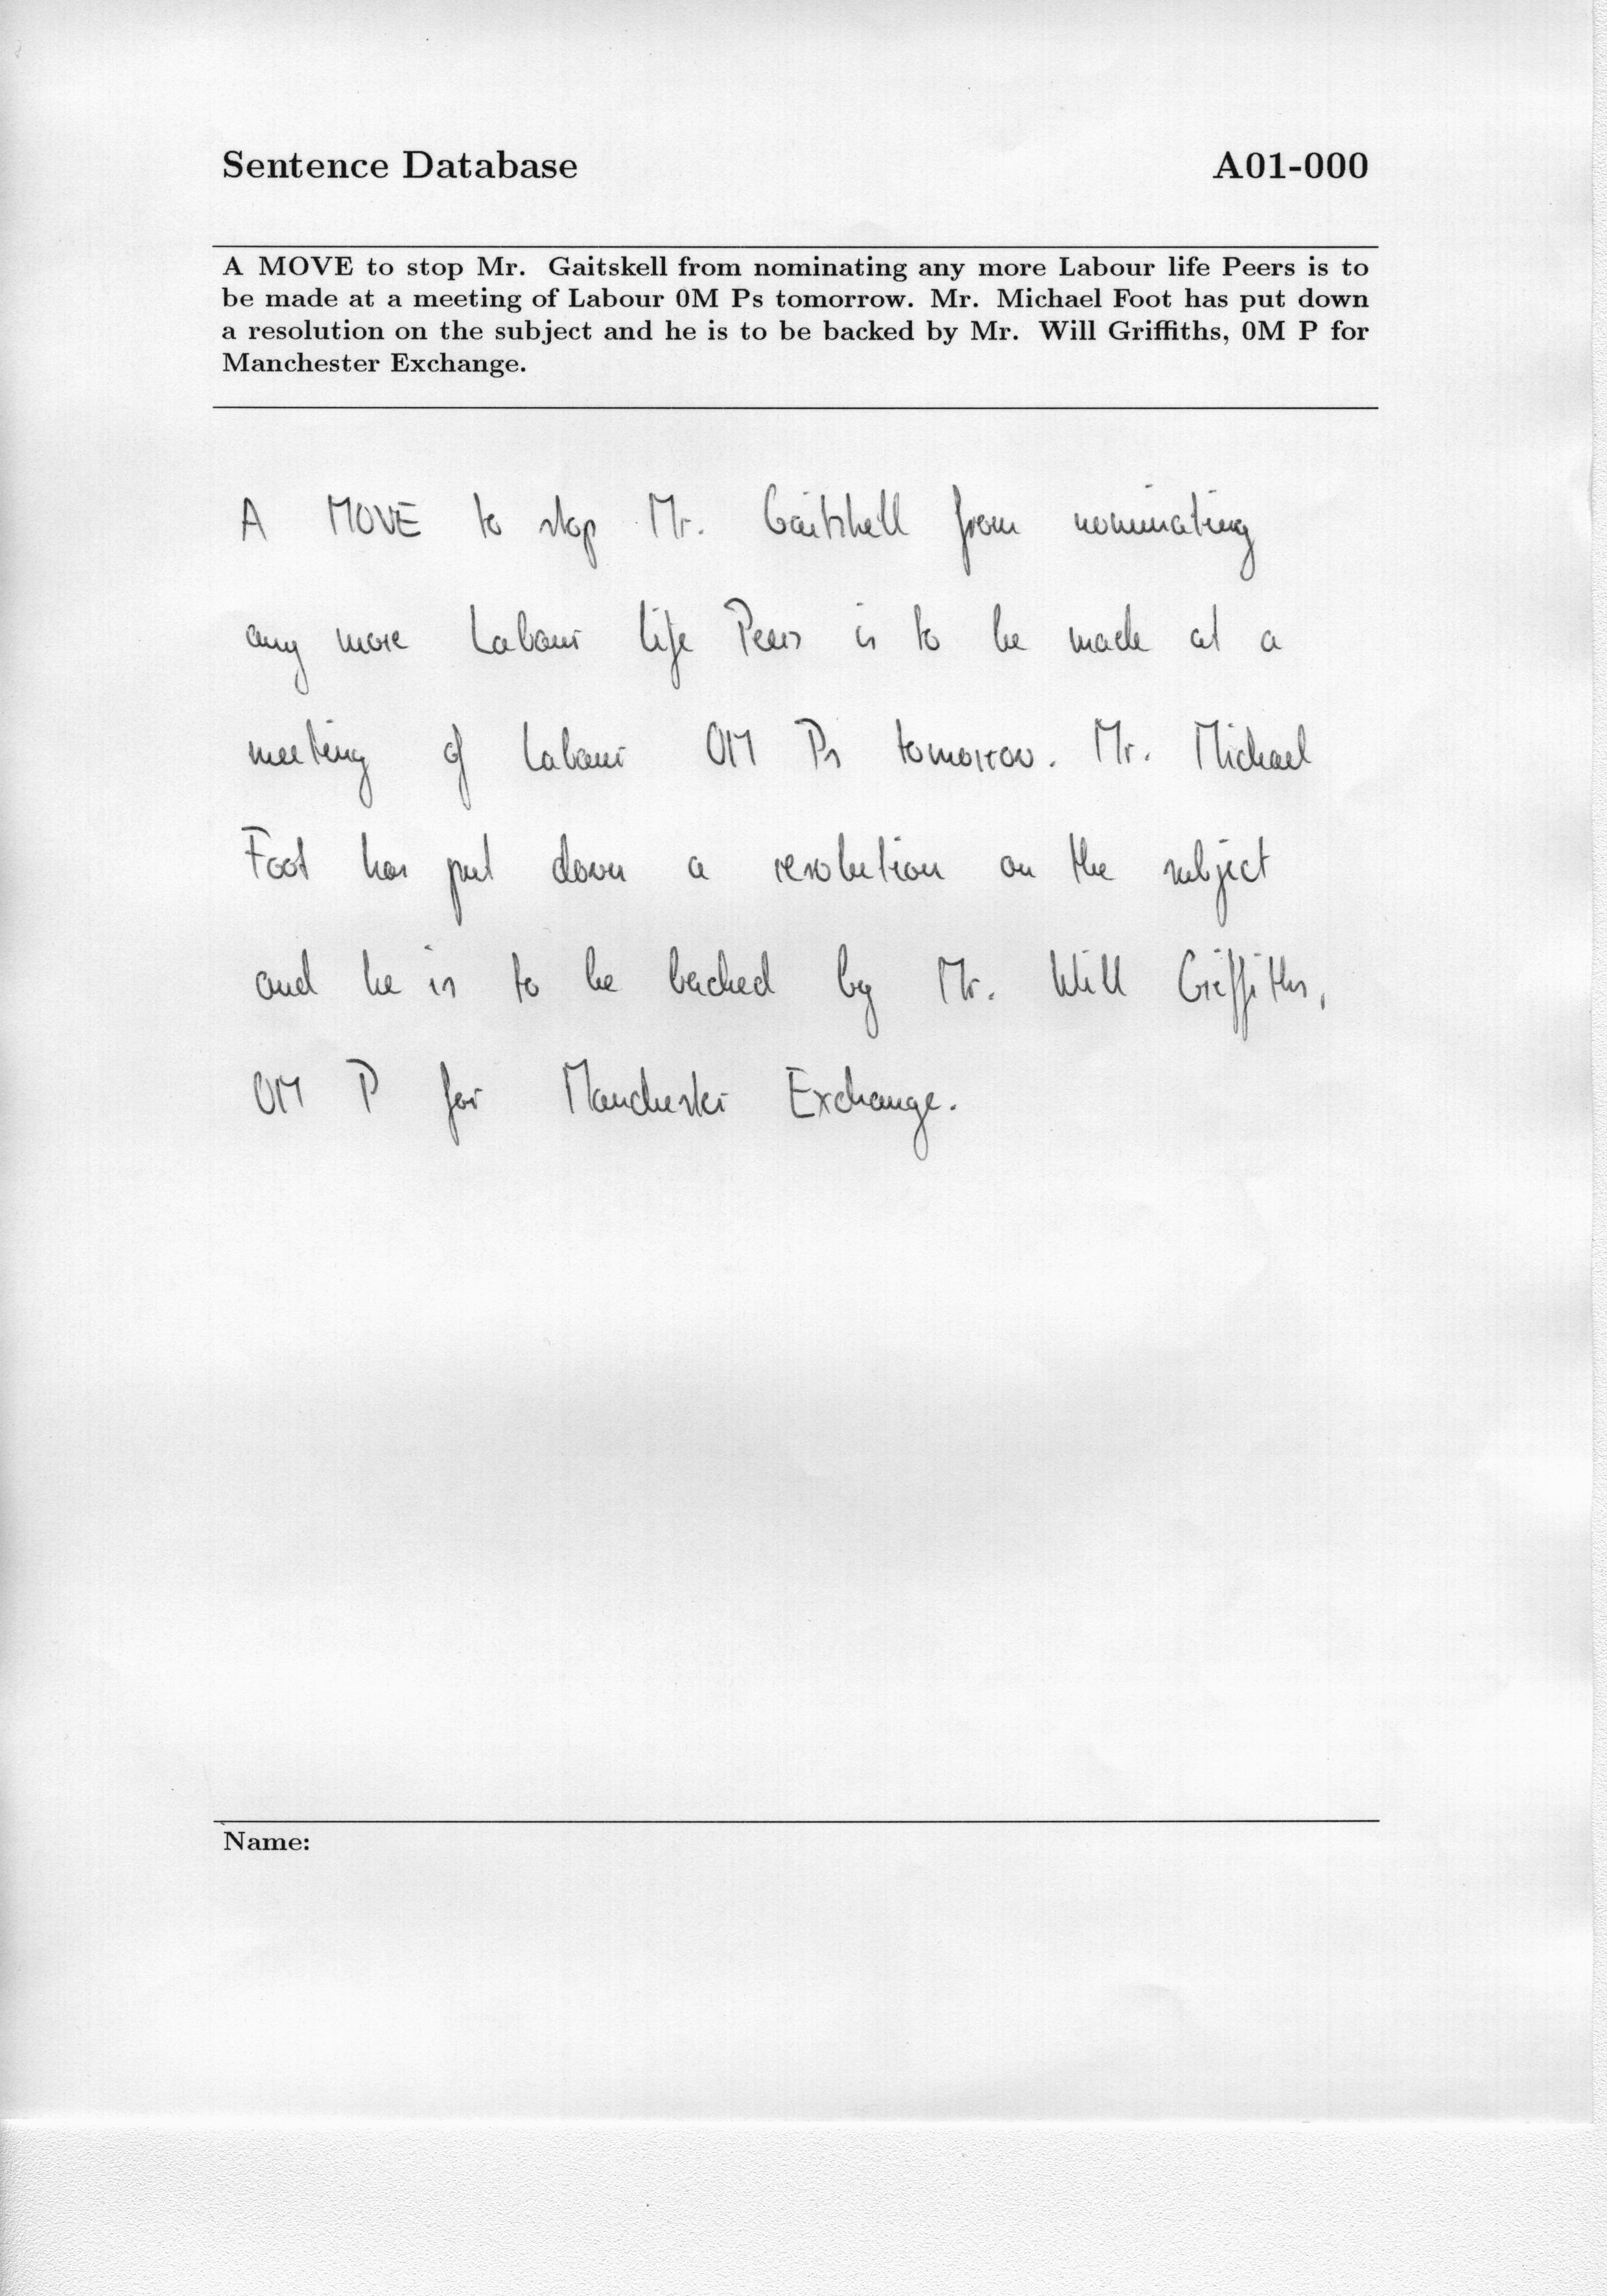

In [2]:
Image(filename = fileList[0], width = 300)

## Step 1. Page Segmentation

Use OpenCV to find lines between sections, and use the coordinates of the lines to break the image into segments.

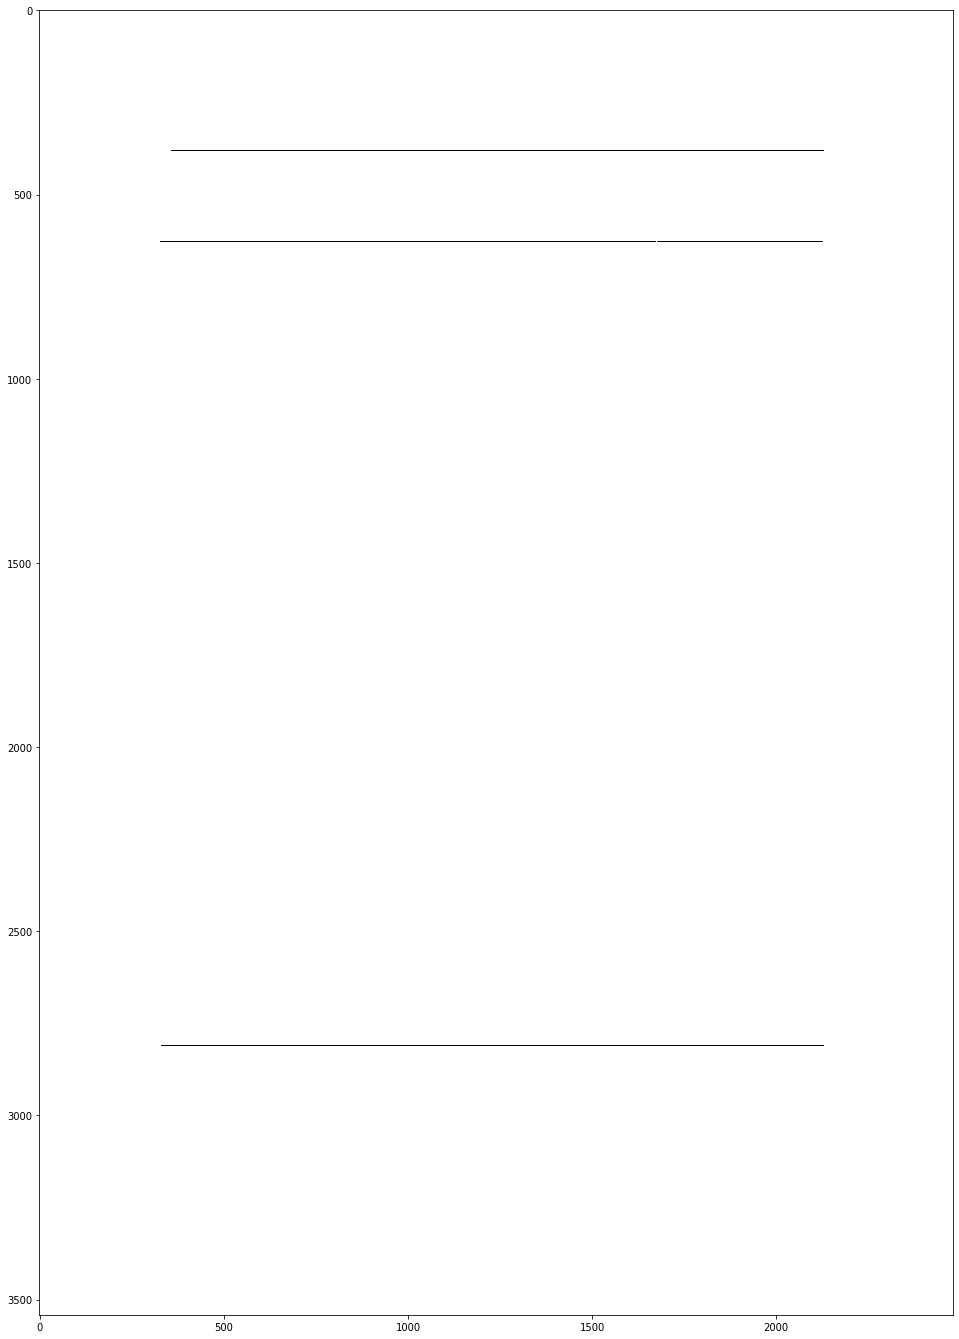

In [10]:
img = fileList[0]

def findHorizontalLines(img):
    img = cv2.imread(img) 
    
    #convert image to greyscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # set threshold to remove background noise
    thresh = cv2.threshold(gray,30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    
    # define rectangle structure (line) to look for: width 100, hight 1. This is a 
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (200,1))
    
    # Find horizontal lines
    lineLocations = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    
    return lineLocations

lineLocations = findHorizontalLines(img)
plt.figure(figsize=(24,24))
plt.imshow(lineLocations, cmap='Greys')

In [11]:
df_lineLocations = pd.DataFrame(lineLocations.sum(axis=1)).reset_index()
df_lineLocations.columns = ['rowLoc', 'LineLength']
df_lineLocations[df_lineLocations['LineLength'] > 0]

rowLoc  LineLength
379      379      113220
380      380      458745
381      381      451350
382      382      249135
628      628      457980
629      629      458490
630      630      334560
2808    2808       80325
2809    2809      458745
2810    2810      458745
2811    2811      310845

In [12]:
df_lineLocations['line'] = 0
df_lineLocations['line'][df_lineLocations['LineLength'] > 100] = 1

df_lineLocations['cumSum'] = df_lineLocations['line'].cumsum()

In [13]:
df_lineLocations.head()

rowLoc  LineLength  line  cumSum
0       0           0     0       0
1       1           0     0       0
2       2           0     0       0
3       3           0     0       0
4       4           0     0       0

In [14]:
import pandasql as ps

query = '''
select row_number() over (order by cumSum) as SegmentOrder
, min(rowLoc) as SegmentStart
, max(rowLoc) - min(rowLoc) as Height
from df_lineLocations
where line = 0
--and CumSum !=0
group by cumSum
'''

df_SegmentLocations  = ps.sqldf(query, locals())
df_SegmentLocations

SegmentOrder  SegmentStart  Height
0             1             0     378
1             2           383     244
2             3           631    2176
3             4          2812     729

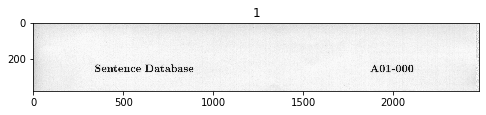

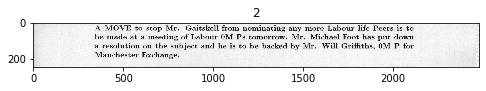

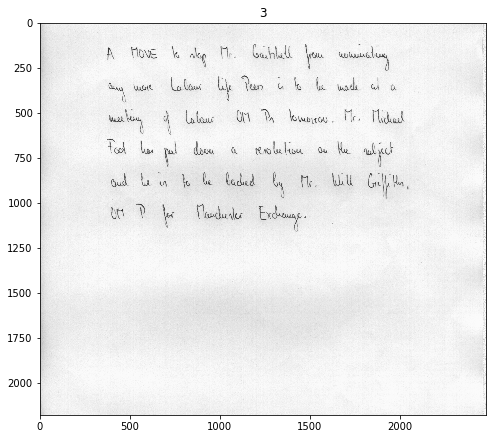

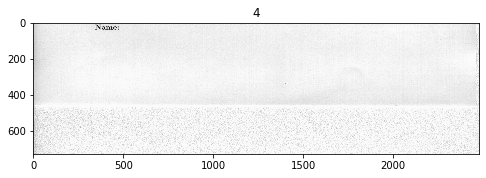

In [26]:
def pageSegmentation1(img, w, df_SegmentLocations):
    img = cv2.imread(img) 
    im2 = img.copy()
    segments = []

    for i in range(len(df_SegmentLocations)):
        y = df_SegmentLocations['SegmentStart'][i]
        h = df_SegmentLocations['Height'][i]

        cropped = im2[y:y + h, 0:w] 
        segments.append(cropped)
        plt.figure(figsize=(8,8))
        plt.imshow(cropped)
        plt.title(str(i+1))        

    return segments

img = fileList[0]
w = lineLocations.shape[1]
segments = pageSegmentation1(img, w, df_SegmentLocations)

# Step 2. Extract Printed Text

In [16]:
# Extract text from image with two columns of contents
import re
import cv2
import pytesseract
from pytesseract import Output

# tell pytesseract where the engine is installed
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'


def extractTextFromImg(segment):
    text = pytesseract.image_to_string(segment, lang='eng')         
    text = text.encode("gbk", 'ignore').decode("gbk", "ignore")
        
    return text

In [17]:
segment = segments[1]
text = extractTextFromImg(segment)
print(text)

A MOVE to stop Mr. Gaitskell from nominating any more Labour life Peers is to
be made at a meeting of Labour 0M Ps tomorrow. Mr. Michael Foot has put down
a resolution on the subject and he is to be backed by Mr. Will Griffiths, OM P for

Manchester Exchange.


In [18]:
segment = segments[2]
text = extractTextFromImg(segment)
print(text)

A MOVE Ie ep Th. Gahlell eu wml
Say st Laban Ly. Yow vb te wok ot o
wat {Latour On  une. - Wel
tod rp dion & ttwolukon ou the aye
gud le cy ee dl \ te. Watt Ce Hn,

yr? \. Voudherles Caden


# Step 3. Extract handwritten text using Google Cloud Vision API

In [19]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:\GoogleCloudPlatform\my-key.json"
print('Credendtials from environ: {}'.format(os.environ.get('GOOGLE_APPLICATION_CREDENTIALS')))

Credendtials from environ: C:\GoogleCloudPlatform\my-key.json


In [22]:

def CloudVisionTextExtractor(handwritings):
    # convert image from numpy to bytes for submittion to Google Cloud Vision
    _, encoded_image = cv2.imencode('.png', handwritings)
    content = encoded_image.tobytes()
    image = vision.types.Image(content=content)
    
    # feed handwriting image segment to the Google Cloud Vision API
    client = vision.ImageAnnotatorClient()
    response = client.document_text_detection(image=image)
    
    return response

def getTextFromVisionResponse(response):
    texts = []
    for page in response.full_text_annotation.pages:
        for i, block in enumerate(page.blocks):  
            for paragraph in block.paragraphs:       
                for word in paragraph.words:
                    word_text = ''.join([symbol.text for symbol in word.symbols])
                    texts.append(word_text)

    return ' '.join(texts)

In [27]:
handwritings = segments[2]
response = CloudVisionTextExtractor(handwritings)
handwrittenText = getTextFromVisionResponse(response)
print(handwrittenText)

Move to slap Mr. Gainbell from unnunating Labour Peus life G to be mache cal a any cuore eeling of labani OM Pn tomatou . Mr. Michael Food her pul down a resolution on the rubject and he in to be bached by Mr. Will Greffe Her , OM for Mancherlei Exchange
